# MODULES AND CONSTANTS

### MODULES AND LIBRARIES

In [436]:
# GENERAL IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse

# DISTANCE FUNCTION
from sklearn.metrics.pairwise import rbf_kernel

### CONSTANTS

In [437]:
SPIRAL_INPUT_FILE = 'Spiral.csv'
CIRCLE_INPUT_FILE = 'Circle.csv'
EPS = 1e-16

# 0 - READ FUNCTIONS

### readSpiralInput
reads the input file containing the spiral data, 
<br> accepts as input the path to the csv file containing the data
<br> returns a pandas dataFrame

In [438]:
def readSpiralInput(path:str=SPIRAL_INPUT_FILE)->pd.DataFrame:
    return pd.read_csv(filepath_or_buffer=path, header=None).set_axis(labels=['x', 'y', 'cluster'], axis=1)

### readCircleInput
reads the input file containing the circle data
<br> accepts as input the path to the csv file containing the data
<br> returns a pandas dataFrame

In [439]:
def readCircleInput(path:str=CIRCLE_INPUT_FILE)->pd.DataFrame:
    return pd.read_csv(filepath_or_buffer=path, header=None).set_axis(labels=['x', 'y'], axis=1)

In [440]:
circle = readCircleInput()
spiral = readSpiralInput()

# 1 - BUILDING W SIMILARITY MATRIX

Given a set of data points X and the similarity function:
$ s_{i, j} = exp\left( - \frac{||X_i - X_j||^2}{2\sigma^2}\right)$

construct the k-nearest neighborhood similarity graph and its adjacency
matrix W using $\sigma = 1$.

In [441]:
def buildSimilarityMatrix(circle:pd.DataFrame, k:int, sigma:int=1):
    matrix = rbf_kernel(circle, gamma=sigma/2)
    np.fill_diagonal(matrix, 0)
    
    mask = np.zeros(matrix.shape, dtype=bool)
    mask[np.arange(matrix.shape[0])[:, None], np.argpartition(-matrix, k, axis=1)[:, :k]] = True
    

    matrix = np.where(mask, matrix, 0)
    
    for i in range(matrix.shape[0]):
        for j in range(matrix[i, :].shape[0]):
            if matrix[i, j] > EPS:
                matrix[j, i] = matrix[i, j]
    
    return matrix

W = buildSimilarityMatrix(spiral[['x', 'y']], 10)


The main problem that may occur when building this matrix is related to the required symmetry.  
Moreover, the given matrix <em>W</em> must be symmetric since we are dealing with a weighted, non-oriented graph.  
However, this may not always be the case because, even if weights are computed symmetrically (i.e., $\forall i,j, s_{i,j} = s_{j,i}$), considering the <em>k</em>-nearest neighbors may create asymmetry:  
If a vertex <em>V</em> is a neighbor of <em>V'</em>, we cannot be sure of the opposite, as shown here.<br>
<b>TO ADD PICTURE </b>
<br>
To address this issue, we can use one of two approaches (relaxing the constraint of having exactly <em>k</em> neighbors):
<ul>
    <li>Impose that if <em>V</em> is a neighbor of <em>V'</em>, then <em>V'</em> is also a neighbor of <em>V</em>, thus potentially allowing more than <em>k</em> neighbors for a single vertex.</li>
    <li>Impose that if <em>V</em> is not a neighbor of <em>V'</em>, then <em>V'</em> is also not a neighbor of <em>V</em>, thus potentially allowing fewer than <em>k</em> neighbors for a single vertex.</li>
</ul>
We have chosen the first approach.

# 2 - BUILD DEGREE MATRIX D AND LAPLACIAN MATRIX L

Construct the degree matrix D and the Laplacian matrix L = D − W.

In [442]:
def buildDegreeMatrix(matrix:np)->np:
    return np.diag(matrix.sum(axis=1))

def buildLaplacianMatrix(D:np, W:np)->np:
    return D-W

### setAsSparseMatrix
Given a matrix as input, returns the same matrix in a sparse format. <br>
We have chosen to use an approach similar to the modified CSR sparse format to prioritize the diagonal of the matrix. <br>
Which is particularly convenient when dealing with matrices such as the degree matrix D. 

In [443]:
def setAsSparseMatrix(matrix:np)->sparse:
    return sparse.dia_array(matrix)

Finally, the Laplacian matrix is built using the previously declared function. <br>
Moreover, since we will only be working with $L$ from now on, we can convert $D$ and $W$ into a sparse matrix format. <br>
We prefer not to convert $L$ since it will still be used for many different purposes. <br>
Due to the structure of $W$ and especially $D$, we opted to convert them into a modified CSR format.

In [444]:
L = buildLaplacianMatrix(D:=buildDegreeMatrix(W), W)
D, W = setAsSparseMatrix(D), setAsSparseMatrix(W)

# 3 - CONNECTED COMPONENT OF THE GRAPHS

Compute the number of connected components of the similarity graph.

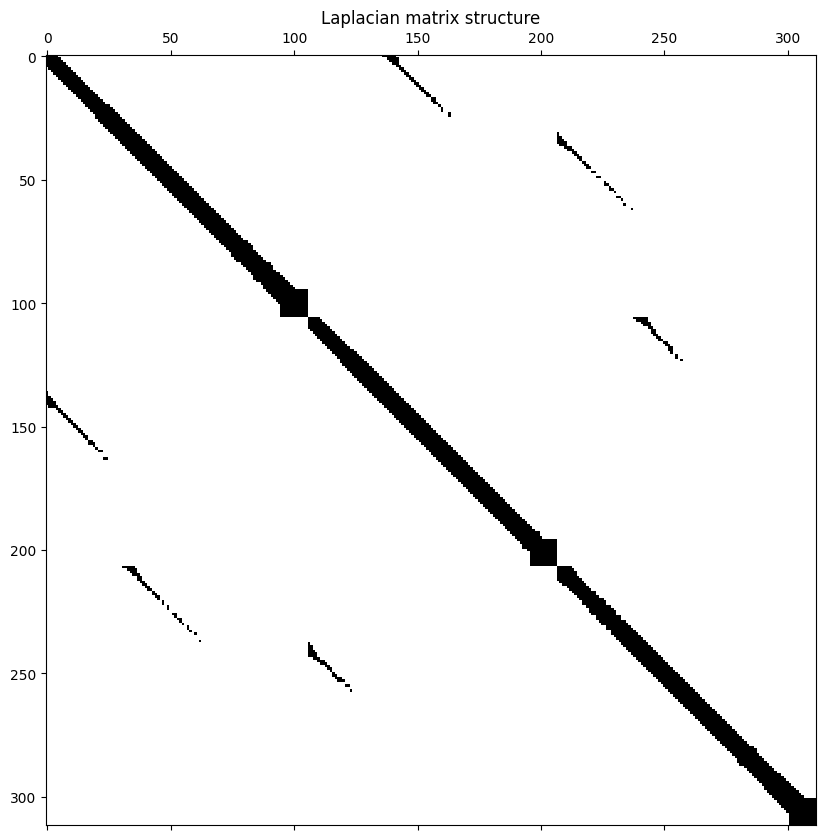

In [445]:
fig, ax = plt.subplots(figsize=(10,10))
plt.spy(L)
ax.set_title('Laplacian matrix structure')
plt.show()

First and foremost, as expected, the Laplacian matrix $L$ is symmetric. <br>
Moreover, it is a sparse matrix, with most of the non-zero elements located near the main diagonal. <br>
Finally, and most importantly, we can conclude that the graph is primarily composed of three main components (represented by the three blocks along the diagonal), which are weakly connected, as indicated by the small black patches far from the main diagonal.

# 4 - EIGENVALUES OF L

Compute some of the small eigenvalues of $L$ and use their values to choose a suitable number of clusters $M$ for the data points. <br>
From what we have previously observed, we can conclude that the graph has $3$ main components. <br>
However, we are going to compute the first $10$ eigenvalues, mainly because the graph also shows $6$ more patches with non-zero values (even though the patches are symmetric), indicating a weak connection between the $3$ main components of the graph."

## USING NUMPY IMPLEMENTATION

We can easily compute eigenvalues using the eig function within the linalg module of numpy.

Computed the following 10 eigenvalues : 
  0.0   0.000197   0.000272   0.004134   0.004381   0.004578   0.017237   0.018386   0.018854   0.040415 


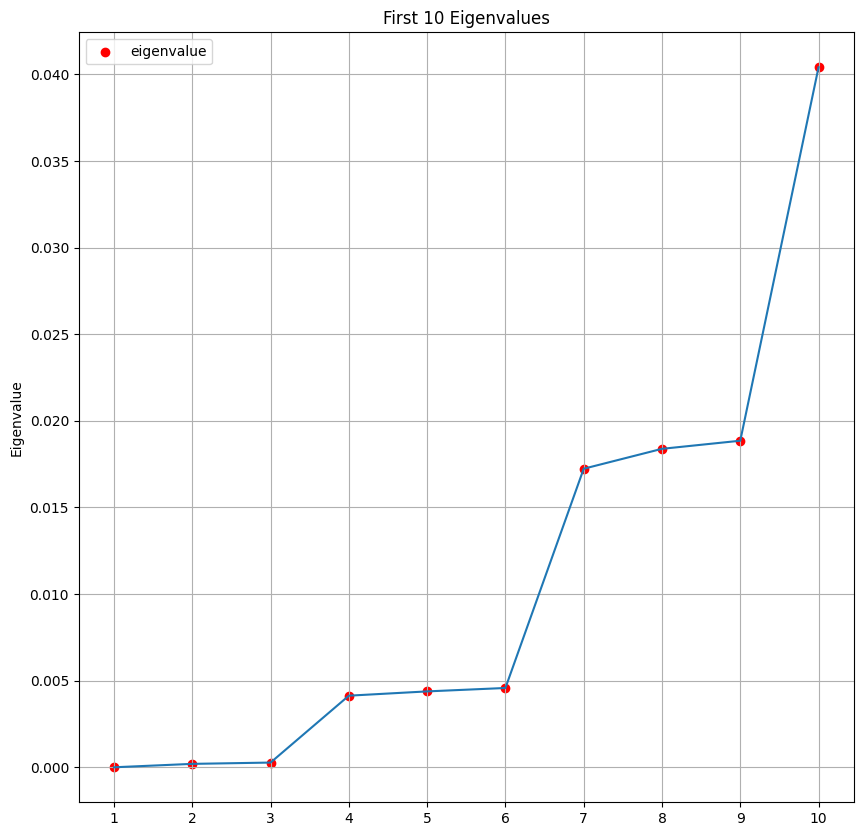

In [466]:
def computeEigenValues(L:np, n:int=10)->None:
    eigVal = np.sort(np.linalg.eig(L)[0])[:n]
    
    print(f"Computed the following {n} eigenvalues : \n", *list(map(lambda x:f" {round(x, 6)} ", eigVal)))

    plt.subplots(1,1,figsize=(10,10))
    plt.plot(values:=range(1, n+1), eigVal)
    plt.scatter(values, eigVal, c='red', label="eigenvalue")
    plt.xticks(values)
    plt.ylabel("Eigenvalue")
    plt.title(f"First {n} Eigenvalues")
    plt.legend(loc='upper left')
    plt.grid(visible=True)
    plt.show()
    
computeEigenValues(L,10)


## INVERSE POWER METHOD

Independently from the method chosen, as expected, the first $3$ eigenvalues are $0$ or are really close to $0$. <br>
Then there is another group of $3$ eigenvalues with values closer to $0.005$ which indicates a fairly weak connection between the three main components. <br>
Moreover there is, also, another group of $3$ eigenvalues, with values higher than the previous one.<br>
Finally, we can see how, starting from the $10^{th}$ eigenvalue, they become bigger and bigger, thus indicating an even stronger connection. 